In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.mode = mode
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        elif mode == 'damage':
            self.index_file = np.loadtxt('../tools/damage_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        if self.mode == 'damage':
            file_path_vib = '../data/z24_damage/7_clean/'+file_to_read+'_vibrations.npy'
            file_path_env = '../data/z24_damage/7_clean/'+file_to_read+'_env.npy'
        else:
            file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
            file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        
        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, z_size, output_size, dropout_p):
        super(Model, self).__init__()
        self.dropout_p = dropout_p

        self.h1 = nn.Linear(input_size, hidden_size)
        self.z  = nn.Linear(hidden_size, z_size)
        self.h2 = nn.Linear(z_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.h1(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.z(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.h2(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.h3(x)
        return x

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100

dataset = z24Dataset(mode='testing', window_size=100, normalize=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
model = torch.load(f='../results/trained_autoencoder_correct.pt', map_location='cpu')
loss_criterion = torch.nn.MSELoss(reduce=False)

FileNotFoundError: [Errno 2] No such file or directory: '../results/trained_autoencoder_correct.pt'

In [5]:
all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float().to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())

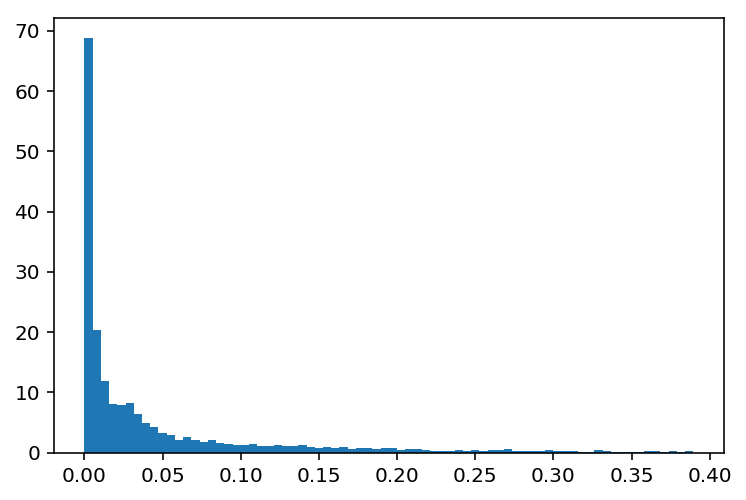

In [6]:
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]
plt.hist(losses_no_outliers, bins='auto' ,density=True)
plt.show()

In [7]:
hist, bin_edges=np.histogram(losses_no_outliers, bins=655)

<BarContainer object of 655 artists>

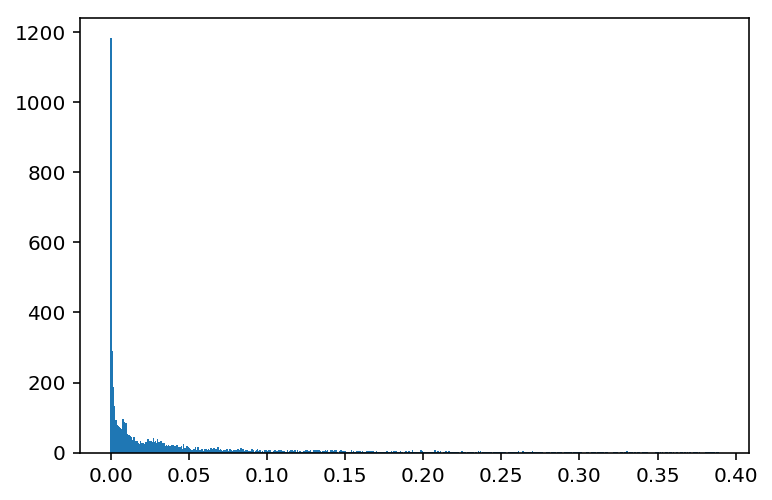

In [8]:
plt.bar(x=bin_edges[:-1], height=hist,width=0.001)

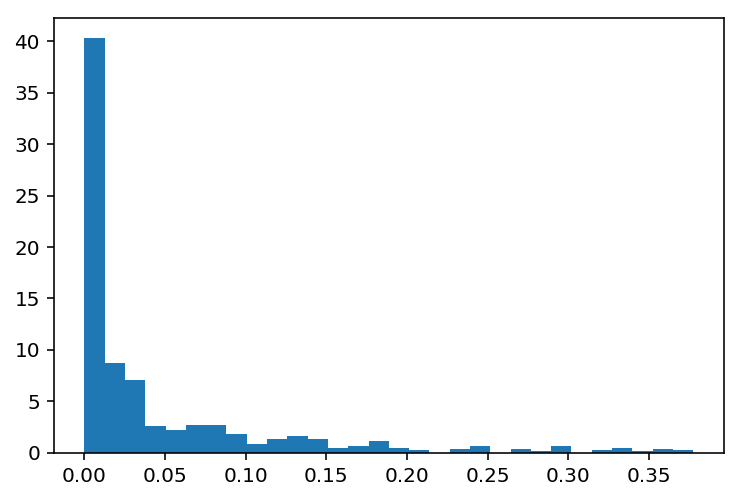

In [30]:
sample = np.random.choice(losses_no_outliers, 655)
plt.hist(sample, bins='auto' ,density=True)
plt.show()

0.03160665184259415

In [34]:
np.save('../results/testset_error_distribution',losses_no_outliers)